# Basic Libraries and Seed Setup

- Import essential libraries for OS operations, randomness control, numerical operations, and PyTorch.
- Fix the random seed across Python's `random`, NumPy, and PyTorch (CPU & GPU) to ensure reproducible results.
- Detect and select the computation device automatically: use GPU if available, otherwise fallback to CPU.
- Print out the selected device to confirm hardware usage.

In [ ]:
# 1. Basic libraries and seed setup
import os
import random
import numpy as np
import torch

# Set seed for reproducibility to ensure consistent results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


# Dataset Preparation and Data Loading

- Define paths for training and validation image directories.
- Specify image size and create data augmentation/transformation pipelines:
  - Training: resizing, random flips, rotations, color jitter, normalization.
  - Validation: resizing and normalization only (no augmentation).
- Load datasets from folders using `ImageFolder`, applying corresponding transforms.
- Create `DataLoader` objects for batching, shuffling (training only), and parallel data loading.
- Print dataset sizes to verify loading.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BASE_DIR    = r"C:\DataSets\CombinedDrowsy"
TRAIN_DIR   = os.path.join(BASE_DIR, "train")
VAL_DIR     = os.path.join(BASE_DIR, "val")

# Transformations for training set: augmentation + normalization
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Dataset & DataLoader
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Train samples: 35997 | Val samples: 8940


# DrowsyNet Model

- Use a pretrained MobileNetV2 as the base feature extractor.
- Freeze all base model layers to avoid training them (fine-tuning only on final layers).
- Add an adaptive average pooling layer to reduce spatial dimensions.
- Include dropout for regularization to prevent overfitting.
- Add a fully connected layer with 2 output neurons for binary classification (drowsy vs. alert).
- In the forward pass:
  - Extract features using the frozen base.
  - Pool and flatten the feature maps.
  - Apply dropout.
  - Pass through the final fully connected layer to get class logits.


In [ ]:
import torch.nn as nn
from torchvision import models

class DrowsyNet(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        base = models.mobilenet_v2(pretrained=True)
        # Freeze all layers to prevent training except the final layers (fine-tuning)
        for p in base.parameters():
            p.requires_grad = False

        self.features = base.features
        self.pool     = nn.AdaptiveAvgPool2d((1,1))
        self.dropout  = nn.Dropout(dropout_rate)
        self.fc       = nn.Linear(base.last_channel, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


# Training and Validation Functions

- `train_one_epoch`:
  - Sets the model to training mode.
  - Iterates over training batches, moves data to the device.
  - Performs forward pass, computes loss, backpropagates, and updates weights.
  - Accumulates total loss and counts correct predictions for accuracy.
  - Returns average loss and accuracy over the entire training dataset.

- `validate`:
  - Sets the model to evaluation mode (disables dropout, batch norm updates).
  - Iterates over validation batches without gradient calculation.
  - Computes loss and counts correct predictions.
  - Returns average loss and accuracy on the validation dataset.


In [7]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct    += (out.argmax(1)==y).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item() * X.size(0)
            correct    += (out.argmax(1)==y).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)


# Bayesian Optimization for Hyperparameter Tuning

- **Bayesian Optimization** is a probabilistic model-based method for global optimization of black-box functions that are expensive to evaluate.
- It builds a surrogate model (often Gaussian Process) to approximate the objective function and uses an acquisition function to decide where to sample next, balancing exploration and exploitation.
- In this context, Bayesian Optimization is used to find optimal hyperparameters for the model, such as learning rate, weight decay, and dropout rate, by maximizing validation accuracy.
- The `objective` function:
  - Initializes the `DrowsyNet` with a specified dropout rate.
  - Applies class-weighted cross-entropy loss to address class imbalance.
  - Uses Adam optimizer configured with learning rate and weight decay.
  - Executes a single epoch of training and validation.
  - Returns the validation accuracy as the optimization target.
- `pbounds` defines the search space for:
  - Learning rate (`lr`) in [1e-5, 1e-3]
  - Weight decay (`wd`) in [1e-6, 1e-3]
  - Dropout rate (`dr`) in [0.2, 0.7]
- This efficient hyperparameter search reduces the number of costly training cycles needed compared to grid or random search.


In [ ]:
from bayes_opt import BayesianOptimization

def objective(lr, wd, dr):
    # lr: learning rate, wd: weight_decay, dr: dropout_rate
    # Initialize the model with given dropout rate
    model = DrowsyNet(dropout_rate=dr).to(device)
    y = train_ds.targets
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = validate(model, val_loader,   criterion)

    # Objective: validation accuracy
    return val_acc

# Define hyperparameter search space bounds
pbounds = {
    'lr': (1e-5, 1e-3),
    'wd': (1e-6, 1e-3),
    'dr': (0.2, 0.7)
}


# Bayesian Optimization Execution and Results

- Suppress warnings for cleaner output.
- Initialize the `BayesianOptimization` object with:
  - The objective function to maximize.
  - The defined hyperparameter bounds.
  - A fixed random seed for reproducibility.
  - Verbose logging for detailed progress info.
- Run the optimization:
  - `init_points=5`: Random initial explorations.
  - `n_iter=15`: Subsequent guided searches based on the surrogate model.
- After optimization, print the best achieved validation accuracy (`Best result`) and corresponding hyperparameters (`Best params`).
- Example output shows a best validation accuracy of approximately 0.91 with specific learning rate, weight decay, and dropout values.
- This process efficiently identifies effective hyperparameters to improve model performance.


In [10]:
import warnings

warnings.filterwarnings('ignore')

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=SEED,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)

print(">> Best result:", optimizer.max['target'])
print(">> Best params:", optimizer.max['params'])


|   iter    |  target   |    lr     |    wd     |    dr     |
-------------------------------------------------------------
| 2         | 0.8868008 | 0.0003807 | 0.0009507 | 0.5659969 |
| 3         | 0.8759507 | 0.0006026 | 0.0001568 | 0.2779972 |
| 4         | 0.7996644 | -.750e-05 | 0.0008663 | 0.5005575 |
| 5         | 0.8711409 | 0.0007109 | -.156e-05 | 0.6849549 |
| 6         | 0.8992170 | 0.0008341 | 0.0002131 | 0.2909124 |
| 7         | 0.8860178 | 0.001     | 0.0003230 | 0.3161822 |
| 8         | 0.8081655 | 0.0009397 | 0.0002256 | 0.3160781 |
| 9         | 0.9100671 | 0.0009079 | 0.0002211 | 0.2908160 |
| 10        | 0.9115212 | 0.0008238 | 0.0002764 | 0.2908122 |
| 11        | 0.8863534 | 0.0005129 | -.039e-05 | 0.2778929 |
| 12        | 0.8630872 | 0.0007867 | 0.0001348 | 0.2907230 |
| 13        | 0.8299776 | 0.0008205 | 0.0002065 | 0.2909128 |
| 14        | 0.8866890 | 0.0009063 | 0.0002139 | 0.2908257 |
| 15        | 0.8911633 | 0.0009829 | 0.0001968 | 0.2909630 |
| 16    

In [ ]:
best = optimizer.max['params']
best_lr = best['lr']
best_wd = best['wd']
best_dr = best['dr']
print(best_lr, best_wd, best_dr)

# Initialize the final model with the best dropout rate
final_model = DrowsyNet(dropout_rate=best_dr).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(
    compute_class_weight('balanced', classes=np.unique(train_ds.targets), y=train_ds.targets),
    dtype=torch.float).to(device))
optimizer_f = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_wd)


0.0008238732603732154 0.0002764889016162441 0.29081222179068594


# Training Loop with Learning Rate Scheduler and Early Stopping

- Use `ReduceLROnPlateau` scheduler to reduce learning rate by half if validation loss plateaus for 3 epochs.
- Initialize variables to track best validation accuracy, patience for early stopping, and training history.
- For each epoch (up to 30):
  1. Train the model for one epoch and validate it.
  2. Step the scheduler based on validation loss; print if learning rate is reduced.
  3. Append training and validation loss and accuracy to history.
  4. Print epoch summary with train/validation accuracy and loss.
  5. Save the model checkpoint if validation accuracy improves; reset patience.
  6. If no improvement for 5 consecutive epochs, stop training early.
- This approach helps avoid overfitting and optimizes training time by dynamically adjusting learning rate and stopping when progress stalls.


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Setup LR scheduler to reduce LR when val loss plateaus
scheduler = ReduceLROnPlateau(optimizer_f, mode='min', factor=0.5, patience=3)

best_val_acc = 0
patience = 0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, 31):
    # Train and validate for one epoch
    tl, ta = train_one_epoch(final_model, train_loader, criterion, optimizer_f)
    vl, va = validate(final_model,   val_loader,   criterion)
    
    # Adjust learning rate based on val loss
    old_lr = optimizer_f.param_groups[0]['lr']
    scheduler.step(vl)
    new_lr = optimizer_f.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"Epoch {epoch:02d}: LR reduced from {old_lr:.1e} to {new_lr:.1e}")
    
    history['train_loss'].append(tl)
    history['train_acc'].append(ta)
    history['val_loss'].append(vl)
    history['val_acc'].append(va)

    print(f"Epoch {epoch:02d}  ➝  Train: {ta:.4f}/{tl:.4f} — Val: {va:.4f}/{vl:.4f}")

    # Early stopping & save best model
    if va > best_val_acc:
        best_val_acc = va
        torch.save(final_model.state_dict(), "best_drowsy_model.pth")
        patience = 0
    else:
        patience += 1
        if patience >= 5:
            print("Early stopping!")
            break


Epoch 01  ➝  Train: 0.8108/0.4220 — Val: 0.9017/0.2878
Epoch 02  ➝  Train: 0.8427/0.3610 — Val: 0.8876/0.2882
Epoch 03  ➝  Train: 0.8417/0.3613 — Val: 0.8662/0.3138
Epoch 04  ➝  Train: 0.8457/0.3615 — Val: 0.8808/0.2895
Epoch 05  ➝  Train: 0.8461/0.3551 — Val: 0.9198/0.2309
Epoch 06  ➝  Train: 0.8443/0.3595 — Val: 0.9168/0.2384
Epoch 07  ➝  Train: 0.8489/0.3522 — Val: 0.9233/0.2264
Epoch 08  ➝  Train: 0.8451/0.3594 — Val: 0.9234/0.2222
Epoch 09  ➝  Train: 0.8439/0.3626 — Val: 0.9200/0.2308
Epoch 10  ➝  Train: 0.8468/0.3574 — Val: 0.9154/0.2293
Epoch 11  ➝  Train: 0.8430/0.3662 — Val: 0.9109/0.2413
Epoch 12  ➝  Train: 0.8453/0.3612 — Val: 0.9306/0.2153
Epoch 13  ➝  Train: 0.8456/0.3579 — Val: 0.9025/0.2531
Epoch 14  ➝  Train: 0.8423/0.3657 — Val: 0.9273/0.2183
Epoch 15  ➝  Train: 0.8433/0.3651 — Val: 0.9289/0.2186
Epoch 16: LR reduced from 8.2e-04 to 4.1e-04
Epoch 16  ➝  Train: 0.8441/0.3627 — Val: 0.9133/0.2354
Epoch 17  ➝  Train: 0.8500/0.3476 — Val: 0.9284/0.2179
Early stopping!


# Training and Validation Metrics Visualization

- Plot accuracy and loss curves over epochs for both training and validation sets.
- Left plot shows how accuracy evolves, helping track learning progress.
- Right plot shows loss trends, useful to detect overfitting or underfitting.
- Visualization aids in diagnosing model performance and guiding further tuning.


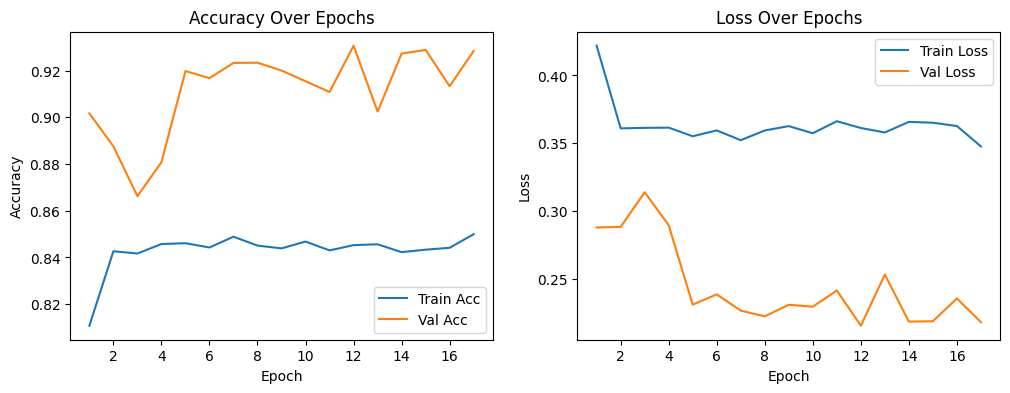

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Final Model Evaluation on Validation Set

- Load the best saved model weights and set the model to evaluation mode.
- Compute final validation loss and accuracy using the validation loader.
- Generate detailed classification metrics including precision, recall, and F1-score per class.
- Display confusion matrix showing true vs predicted labels.
- The results indicate strong balanced performance between "drowsy" and "non_drowsy" classes, with an overall accuracy of ~93%.
- Confusion matrix confirms most predictions are correct, with few misclassifications.


In [ ]:
# Load the best saved model weights
final_model.load_state_dict(torch.load("best_drowsy_model.pth", map_location=device))
final_model.eval()

# Calculate final validation loss and accuracy
val_loss, val_acc = validate(final_model, val_loader, criterion)
print(f"Final Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        out = final_model(X).argmax(1).cpu().numpy()
        all_preds.extend(out)
        all_labels.extend(y.numpy())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Final Val Acc: 0.9306 | Val Loss: 0.2153
              precision    recall  f1-score   support

      drowsy       0.94      0.93      0.93      4760
  non_drowsy       0.92      0.93      0.93      4180

    accuracy                           0.93      8940
   macro avg       0.93      0.93      0.93      8940
weighted avg       0.93      0.93      0.93      8940

Confusion Matrix:
 [[4417  343]
 [ 277 3903]]


# Confusion Matrix Visualization

- Load the trained model and prepare for evaluation.
- Aggregate predictions and true labels for the entire validation dataset.
- Calculate the confusion matrix to analyze classification performance.
- Display the confusion matrix using a blue color map for clear visual distinction.
- Axes are labeled to show true vs predicted classes, aiding error analysis.


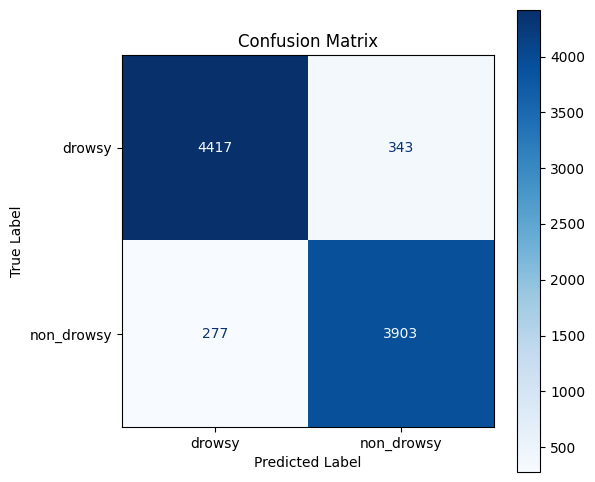

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

final_model.load_state_dict(torch.load("best_drowsy_model.pth", map_location=device))
final_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        out = final_model(X).argmax(dim=1).cpu().numpy()
        all_preds.extend(out)
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_ds.classes)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()
